In [1]:
import pandas as pd

c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\Users\mt01034\Anaconda3\envs\tf-env\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
df = pd.read_csv('../data/Finalplfam_id_Multilabel_Ecoli_data.csv', index_col=0)

C:\Users\mt01034\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (6,18,29,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:

Y=df[['ampicillin',
       'amoxicillin_clavulanic_acid', 'cefoxitin', 'ceftriaxone',
       'chloramphenicol', 'ciprofloxacin', 'gentamicin', 'streptomycin',
       'tetracycline', 'trimethoprim_sulphamethoxazole', 'meropenem',
       'cefepime', 'ceftazidime', 'piperacillin_tazobactam', 'amikacin',
       'ampicillin_sulbactam', 'cefotaxime', 'cefalothin', 'ertapenem',
       'imipenem', 'levofloxacin', 'nitrofurantoin', 'tigecycline',
       'cefazolin', 'aztreonam', 'cefuroxime', 'tobramycin',
       'trimethoprim', 'amoxicillin', 'colistin', 'norfloxacin',
       'sulfamethoxazole']]
droppeddf=df.drop(columns=['genome_id', 'genome_name', 'taxon_id', 'ampicillin',
       'amoxicillin_clavulanic_acid', 'cefoxitin', 'ceftriaxone',
       'chloramphenicol', 'ciprofloxacin', 'gentamicin', 'streptomycin',
       'tetracycline', 'trimethoprim_sulphamethoxazole', 'meropenem',
       'cefepime', 'ceftazidime', 'piperacillin_tazobactam', 'amikacin',
       'ampicillin_sulbactam', 'cefotaxime', 'cefalothin', 'ertapenem',
       'imipenem', 'levofloxacin', 'nitrofurantoin', 'tigecycline',
       'cefazolin', 'aztreonam', 'cefuroxime', 'tobramycin',
       'trimethoprim', 'amoxicillin', 'colistin', 'norfloxacin',
       'sulfamethoxazole'])
X=droppeddf

In [4]:
# set the seeds so that we get the same initialization across different trials
seed_numpy = 1989
seed_tensorflow = 1989
seed_value=1989

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

In [6]:
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
import random
import os

random.seed(seed_numpy)
tf.compat.v1.random.set_random_seed(seed_tensorflow)
os.environ['PYTHONHASHSEED'] = str(seed_value)

In [8]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
#kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1989)

In [9]:
X.shape

(2775, 16345)

In [10]:
labels=['ampicillin',
       'amoxicillin_clavulanic_acid', 'cefoxitin', 'ceftriaxone',
       'chloramphenicol', 'ciprofloxacin', 'gentamicin', 'streptomycin',
       'tetracycline', 'trimethoprim_sulphamethoxazole', 'meropenem',
       'cefepime', 'ceftazidime', 'piperacillin_tazobactam', 'amikacin',
       'ampicillin_sulbactam', 'cefotaxime', 'cefalothin', 'ertapenem',
       'imipenem', 'levofloxacin', 'nitrofurantoin', 'tigecycline',
       'cefazolin', 'aztreonam', 'cefuroxime', 'tobramycin',
       'trimethoprim', 'amoxicillin', 'colistin', 'norfloxacin',
       'sulfamethoxazole']

In [11]:
lenList=len(labels)

In [12]:
X=X.fillna(0)

In [13]:
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metric(history, labels, n,metrics):
  # Use a log scale to show the wide range of values.
  for metric in metrics:
        plt.semilogy(history.epoch, history.history[metric],
                color=colors[n], label='Train '+labels[n])
        plt.semilogy(history.epoch, history.history['val_'+metric],
                color=colors[n], label='Val '+labels[n],
                linestyle="--")
        n=n+1
  plt.xlabel('Epoch')
  plt.ylabel('Metrics')

  plt.legend()
  plt.savefig('../output/'+'Plot_masked_'.join(labels)+'.png')

In [14]:
mask_value=-1

In [15]:
def masked_accuracy(y_true, y_pred):
    dtype = K.floatx()
    total = K.sum(K.cast(K.not_equal(y_true, mask_value), dtype))
    #total=K.cast(len(y_true),dtype)
    correct = K.sum(K.cast(K.equal(y_true, K.round(y_pred)), dtype))
    #print(correct,total)
    return correct / total

In [16]:
from sklearn.utils import class_weight

In [17]:
def masked_loss_function(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    #print(mask)
    #print((y_true * mask))
    return K.binary_crossentropy(y_true * mask, y_pred * mask)

In [18]:
def masked_f1(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred*mask, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true*mask, 0, 1)))

        recall = TP / (Positives+K.epsilon())    
        return recall 


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred *mask, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred*mask, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision 

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))
  

In [19]:
def masked_precision(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    TP = K.sum(K.round(K.clip(y_true * y_pred *mask, 0, 1)))
    Pred_Positives = K.sum(K.round(K.clip(y_pred*mask, 0, 1)))

    precision = TP / (Pred_Positives+K.epsilon())
    return precision 

In [20]:

def masked_recall(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    TP = K.sum(K.round(K.clip(y_true * y_pred*mask, 0, 1)))
    Positives = K.sum(K.round(K.clip(y_true*mask, 0, 1)))

    recall = TP / (Positives+K.epsilon())    
    return recall 

In [21]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      masked_accuracy,
      masked_precision,
      masked_recall,
      masked_f1
]

In [22]:
EPOCHS = 50
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_masked_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [23]:
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback
from tf_explain.callbacks.vanilla_gradients import VanillaGradients
from tf_explain.callbacks.gradients_inputs import GradientsInputsCallback

In [24]:
output_dir='../output/'

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Dropout, MaxPooling1D, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
def build_conv1D_model(train_data_reshaped):
    n_timesteps = train_data_reshaped.shape[1] #13
    n_features  = train_data_reshaped.shape[2] #1 
    model = Sequential(name="model_conv1D")
    model.add(Input(shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1"))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
    model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu', name="Dense_1"))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu', name="Dense_1_1"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu',name="Dense_2"))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='sigmoid',name="Dense_3"))
   # model.add(Dense(n_labels, name="Dense_2"))

    return model


In [27]:
import shap

In [160]:
trainX, testX, trainy, testy = train_test_split(X, Y, test_size=0.2, random_state=1989)
train_trainX, train_validateX, train_trainy, train_validatey = train_test_split(trainX, trainy, test_size=0.2, random_state=1989)

trainy=train_trainy.reset_index(drop=True)
trainX=train_trainX.reset_index(drop=True)
validatey=train_validatey.reset_index(drop=True)
validateX=train_validateX.reset_index(drop=True)

    
trainy=trainy.fillna(-1)
validatey=validatey.fillna(-1)
Testy=testy.fillna(-1)

trainy=trainy.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [0,0,-1,-1])
validatey=validatey.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [0,0,-1,-1])
Testy=Testy.replace(['Not defined','Susceptible-dose dependent',0.5,'0.5'], [-1,-1,-1,-1])
    #print(trainy)
train_labels = np.array(trainy).astype(np.float32)
val_labels = np.array(validatey).astype(np.float32)
test_labels = np.array(Testy).astype(np.float32)
#train_features = np.array(trainX).astype(np.float32)
#val_features = np.array(validateX).astype(np.float32)
#test_features = np.array(testX).astype(np.float32)
    
input_dimension = 1 
train_sample_size = trainX.shape[0] # number of samples in train set
test_sample_size = testX.shape[0] # number of samples in train set
valid_sample_size = validateX.shape[0] # number of samples in train set
time_steps  = testX.shape[1] # number of features in train set

test_data_reshaped = testX.values.reshape(test_sample_size,time_steps,input_dimension)
train_data_reshaped = trainX.values.reshape(train_sample_size,time_steps,input_dimension)
val_data_reshaped = validateX.values.reshape(valid_sample_size,time_steps,input_dimension)

model = build_conv1D_model(train_data_reshaped)
#model = tf.keras.models.load_model("../output/maskmodel.h5", custom_objects={'masked_loss_function':                   
#masked_loss_function,'masked_accuracy': masked_accuracy, 'masked_precision': masked_precision,
#'masked_recall': masked_recall, 'masked_f1': masked_f1})
model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss= masked_loss_function,
      metrics=METRICS)

baseline_history = model.fit(
        train_data_reshaped,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
        callbacks=[early_stopping],
        validation_data=(val_data_reshaped, val_labels))

    # calculating test accuracy
results = model.evaluate(test_data_reshaped, test_labels, batch_size=BATCH_SIZE, verbose=1)
print (results)
print(results[1],results[2],results[3],results[4])

Epoch 1/50
56/56 [==============================] - 45s 802ms/step - loss: 0.1890 - masked_accuracy: 0.6966 - masked_precision: 0.5032 - masked_recall: 0.4249 - masked_f1: 0.4530 - val_loss: 0.1627 - val_masked_accuracy: 0.7315 - val_masked_precision: 0.6856 - val_masked_recall: 0.4278 - val_masked_f1: 0.5248
Epoch 2/50
56/56 [==============================] - 45s 802ms/step - loss: 0.1394 - masked_accuracy: 0.7742 - masked_precision: 0.6399 - masked_recall: 0.5599 - masked_f1: 0.5930 - val_loss: 0.1306 - val_masked_accuracy: 0.8019 - val_masked_precision: 0.7751 - val_masked_recall: 0.6095 - val_masked_f1: 0.6802
Epoch 3/50
56/56 [==============================] - 45s 803ms/step - loss: 0.1149 - masked_accuracy: 0.8233 - masked_precision: 0.7145 - masked_recall: 0.6741 - masked_f1: 0.6913 - val_loss: 0.1112 - val_masked_accuracy: 0.8431 - val_masked_precision: 0.7940 - val_masked_recall: 0.7425 - val_masked_f1: 0.7660
Epoch 4/50
56/56 [==============================] - 45s 800ms/step 

In [38]:
X.columns

Index(['PLF_561_00000047', 'PLF_561_00004324', 'PLF_561_00003342',
       'PLF_561_00000669', 'PLF_561_00003472', 'PLF_561_00001353',
       'PLF_561_00000725', 'PLF_561_00003292', 'PLF_561_00003677',
       'PLF_561_00003805',
       ...
       'PLF_561_00033675', 'PLF_561_00032062', 'PLF_561_00085247',
       'PLF_561_00087703', 'PLF_561_00019755', 'PLF_561_00086253',
       'PLF_561_00047526', 'PLF_561_00047257', 'PLF_561_00035514',
       'PLF_561_00108032'],
      dtype='object', length=16345)

In [48]:
def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    #print(img_input.shape)
    images = tf.cast(img_input, tf.float32)
    #print(images.shape)
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        #print (preds)
        top_class = preds[:, top_pred_idx]
        #print (top_class)


    grads = tape.gradient(top_class, images)
    return grads

In [49]:
def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_input.shape).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    #print(img_input.shape)
    #print(baseline.shape)
    #print((img_input - baseline))
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 2. Preprocess the interpolated images
    #interpolated_image = xception.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        #img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    #avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input[0] - baseline[0]) * grads
    return integrated_grads

In [51]:
TotShape=[]

In [52]:
preds=model.predict(test_data_reshaped)

In [53]:
for i in range(test_data_reshaped.shape[0]):
    top_pred_idx = tf.argmax(preds[i])
    test_data_reshaped_i=test_data_reshaped[i].reshape(1,test_data_reshaped[i].shape[0],test_data_reshaped[i].shape[1])
    igrads = get_integrated_gradients(test_data_reshaped_i, top_pred_idx=top_pred_idx, num_steps=50)
    avg_grads = tf.reduce_mean(igrads, axis=0)
    TotShape.append(avg_grads)

In [54]:
for va in TotShape:
    print(va.shape)

(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)
(16345, 1)

In [55]:
trainX.columns

Index(['PLF_561_00000047', 'PLF_561_00004324', 'PLF_561_00003342',
       'PLF_561_00000669', 'PLF_561_00003472', 'PLF_561_00001353',
       'PLF_561_00000725', 'PLF_561_00003292', 'PLF_561_00003677',
       'PLF_561_00003805',
       ...
       'PLF_561_00033675', 'PLF_561_00032062', 'PLF_561_00085247',
       'PLF_561_00087703', 'PLF_561_00019755', 'PLF_561_00086253',
       'PLF_561_00047526', 'PLF_561_00047257', 'PLF_561_00035514',
       'PLF_561_00108032'],
      dtype='object', length=16345)

In [56]:
TotShapedf = pd.DataFrame(columns=trainX.columns.values)
for shp in TotShape:
    Valuelist=[]
    with tf.compat.v1.Session() as sess:  
        for value in (shp.numpy()):
            [singleitem] = value
            Valuelist.append(singleitem)
    a_series = pd.Series(Valuelist, index = trainX.columns)
    TotShapedf = TotShapedf.append(a_series, ignore_index=True)

In [57]:
TotShapedf

,PLF_561_00000047,PLF_561_00004324,PLF_561_00003342,PLF_561_00000669,PLF_561_00003472,PLF_561_00001353,PLF_561_00000725,PLF_561_00003292,PLF_561_00003677,PLF_561_00003805,...,PLF_561_00033675,PLF_561_00032062,PLF_561_00085247,PLF_561_00087703,PLF_561_00019755,PLF_561_00086253,PLF_561_00047526,PLF_561_00047257,PLF_561_00035514,PLF_561_00108032
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
mad = TotShapedf.mad()
print (mad)

PLF_561_00000047    0.0
PLF_561_00004324    0.0
PLF_561_00003342    0.0
PLF_561_00000669    0.0
PLF_561_00003472    0.0
                   ... 
PLF_561_00086253    0.0
PLF_561_00047526    0.0
PLF_561_00047257    0.0
PLF_561_00035514    0.0
PLF_561_00108032    0.0
Length: 16345, dtype: float32


In [60]:
mad.to_csv('../output/MAD_IG_FEatures.csv')

In [62]:
#avg_grads.shape
listoftuple=[(i,e) for i, e in enumerate(mad) if e != 0]
#value=[e for i, e in enumerate(mad) if e != 0]
#listoftuple
from operator import itemgetter, attrgetter    
listoftuple1=sorted(listoftuple, key=itemgetter(1),reverse=True)


In [101]:
listoftuple1

[(7100, 0.07391117513179779),
 (7712, 0.026697320863604546),
 (9532, 0.025323640555143356),
 (9751, 0.013399984687566757),
 (11372, 0.013057300820946693),
 (6396, 0.010674215853214264),
 (7525, 0.010549502447247505),
 (7721, 0.010486087761819363),
 (10116, 0.010209597647190094),
 (11373, 0.010198640637099743),
 (7478, 0.009953566826879978),
 (7538, 0.009204271249473095),
 (9945, 0.008607490919530392),
 (6374, 0.008458852767944336),
 (6600, 0.0083833122625947),
 (7780, 0.007984641008079052),
 (8306, 0.007945830933749676),
 (7071, 0.007670943159610033),
 (7713, 0.00761374132707715),
 (7709, 0.0074256183579564095),
 (9377, 0.007201668340712786),
 (12121, 0.007055416237562895),
 (7906, 0.006984648294746876),
 (5058, 0.006937227211892605),
 (11378, 0.006853443570435047),
 (5602, 0.006823795847594738),
 (6862, 0.0068022566847503185),
 (7072, 0.006671652663499117),
 (5722, 0.006640701089054346),
 (7105, 0.006599387153983116),
 (3696, 0.0063555496744811535),
 (7106, 0.006296911276876926),
 (66

In [63]:
vardf=TotShapedf.var()

In [104]:
dfmean=TotShapedf.mean(axis=0)

In [110]:
indexlist=[]
vallist=[]
n=0
for i,val in listoftuple1:
    print(X.columns[i])
    indexlist.append(X.columns[i])
    vallist.append(val)
    print(vardf[i])
    print (dfmean[i])
    #print(n)
    #if (n >25):
    #    break
    df2 = pd.DataFrame({"ID":[X.columns[i]],
                    "MAD":[val], 
                    "Var":[vardf[i]],
                    "val":[dfmean[i]]})
    if (n==0):
        df1=df2
    else:
        df1=df1.append(df2, ignore_index = True)
    n=n+1
df1.to_csv('../output/IG_Feature_final.csv')


PLF_561_00004782
0.009346801
0.062074225
PLF_561_00015082
0.001694389
0.019072024
PLF_561_00051514
0.0020244822
-0.013667922
PLF_561_00007970
0.00045834837
0.00808275
PLF_561_00013716
0.00044924303
0.007549909
PLF_561_00003800
0.0002471102
0.009292191
PLF_561_00194287
0.00036070612
-0.006756675
PLF_561_00005453
0.00026227676
-0.0075745704
PLF_561_00032227
0.0003402309
0.0058420077
PLF_561_00008661
0.0002861372
0.0058710924
PLF_561_00004767
0.00022980082
-0.0072558173
PLF_561_00006645
0.00027497308
0.005002192
PLF_561_00006369
0.0003632951
0.004740352
PLF_561_00004266
0.00022899774
-0.0052649938
PLF_561_00003934
0.00025166495
0.004700931
PLF_561_00005188
0.00016349475
0.005555843
PLF_561_00006148
0.00012524135
0.005187833
PLF_561_00005227
0.00012331261
0.0054089827
PLF_561_00050366
0.000339891
0.00417047
PLF_561_00004864
0.00016480229
-0.0041948864
PLF_561_00009597
0.00016451393
0.004104367
PLF_561_00012859
0.00019165923
0.0037071593
PLF_561_00004757
9.955783e-05
-0.004903461
PLF_561_00

In [111]:
indexlist

['PLF_561_00004782',
 'PLF_561_00015082',
 'PLF_561_00051514',
 'PLF_561_00007970',
 'PLF_561_00013716',
 'PLF_561_00003800',
 'PLF_561_00194287',
 'PLF_561_00005453',
 'PLF_561_00032227',
 'PLF_561_00008661',
 'PLF_561_00004767',
 'PLF_561_00006645',
 'PLF_561_00006369',
 'PLF_561_00004266',
 'PLF_561_00003934',
 'PLF_561_00005188',
 'PLF_561_00006148',
 'PLF_561_00005227',
 'PLF_561_00050366',
 'PLF_561_00004864',
 'PLF_561_00009597',
 'PLF_561_00012859',
 'PLF_561_00004757',
 'PLF_561_00105022',
 'PLF_561_00057682',
 'PLF_561_00003863',
 'PLF_561_00029585',
 'PLF_561_00005448',
 'PLF_561_00003722',
 'PLF_561_00014914',
 'PLF_561_00004206',
 'PLF_561_00058863',
 'PLF_561_00007868',
 'PLF_561_00003802',
 'PLF_561_00000020',
 'PLF_561_00003643',
 'PLF_561_00004564',
 'PLF_561_00000117',
 'PLF_561_00049890',
 'PLF_561_00017351',
 'PLF_561_00003059',
 'PLF_561_00005659',
 'PLF_561_00005323',
 'PLF_561_00009406',
 'PLF_561_00006459',
 'PLF_561_00004134',
 'PLF_561_00018194',
 'PLF_561_000

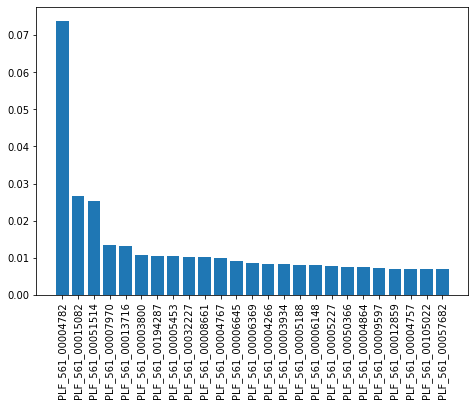

In [112]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation='vertical')
ax.bar(indexlist[:25],vallist[:25])
plt.show()

In [113]:
meanvaldf=vardf.mean(axis=0)
meanvaldf

3.2624011510051787e-06

In [147]:
len(indexlist)

10466

In [117]:
xsh=X[indexlist[:1000]]
xsh.shape

(2775, 1000)

In [161]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
kfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1989)

In [166]:
accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
flist=[]
for train_index, test_index in kfold.split(X[indexlist[:500]], Y):
    # split data into train/test sets
    x_train_tfidf = X[indexlist[:500]].iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_test_tfidf = X[indexlist[:500]].iloc[test_index]
    y_test_tfidf = Y.iloc[test_index]
    trainX, validateX, trainyp, validatey = train_test_split(x_train_tfidf, y_train_tfidf, test_size=0.2, random_state=1989)
    trainyp=trainyp.reset_index(drop=True)
    trainX=trainX.reset_index(drop=True)
    validatey=validatey.reset_index(drop=True)
    validateX=validateX.reset_index(drop=True)

    
    trainy=trainyp.fillna(-1)
    validatey=validatey.fillna(-1)
    Testy=pd.DataFrame(y_test_tfidf).fillna(-1)

    trainy=trainy.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [-1,-1,-1,-1])
    validatey=validatey.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [-1,-1,-1,-1])
    Testy=Testy.replace(['Not defined','Susceptible-dose dependent',0.5,'0.5'], [-1,-1,-1,-1])
    #print(trainy)
    train_labels = np.array(trainy).astype(np.float32)
    val_labels = np.array(validatey).astype(np.float32)
    test_labels = np.array(Testy).astype(np.float32)
    train_features = np.array(trainX).astype(np.float32)
    val_features = np.array(validateX).astype(np.float32)
    test_features = np.array(x_test_tfidf).astype(np.float32)
    
    input_dimension = 1 
    train_sample_size = trainX.shape[0] # number of samples in train set
    test_sample_size = x_test_tfidf.shape[0] # number of samples in train set
    valid_sample_size = validateX.shape[0] # number of samples in train set
    time_steps  = x_test_tfidf.shape[1] # number of features in train set

    test_data_reshaped = test_features.reshape(test_sample_size,time_steps,input_dimension)
    train_data_reshaped = train_features.reshape(train_sample_size,time_steps,input_dimension)
    val_data_reshaped = val_features.reshape(valid_sample_size,time_steps,input_dimension)

    #weight2=weight[:,1:3]
    model = build_conv1D_model(train_data_reshaped)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss= masked_loss_function,
      metrics=METRICS)
    #model.summary()
    '''explaincallbacks = [
    GradientsInputsCallback(
        validation_data=(val_data_reshaped, val_labels),
         class_index=0,
        output_dir=output_dir,
    ),
]'''
    baseline_history = model.fit(
        train_data_reshaped,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
        callbacks=[early_stopping],
        validation_data=(val_data_reshaped, val_labels))
    
    # calculating test accuracy
    results = model.evaluate(test_data_reshaped, test_labels, batch_size=BATCH_SIZE, verbose=1)
    #print (results)
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    flist.append(results[4])
    #explainer = shap.DeepExplainer(model,train_data_reshaped)
    #shap_values = explainer.shap_values(test_data_reshaped)
    #print (shap_values)
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(flist), np.std(flist))

Epoch 1/50
56/56 [==============================] - 2s 33ms/step - loss: 0.1782 - masked_accuracy: 0.6901 - masked_precision: 0.5154 - masked_recall: 0.4656 - masked_f1: 0.4788 - val_loss: 0.1667 - val_masked_accuracy: 0.7442 - val_masked_precision: 0.6500 - val_masked_recall: 0.4329 - val_masked_f1: 0.5151
Epoch 2/50
56/56 [==============================] - 2s 30ms/step - loss: 0.1451 - masked_accuracy: 0.7536 - masked_precision: 0.6385 - masked_recall: 0.4633 - masked_f1: 0.5319 - val_loss: 0.1340 - val_masked_accuracy: 0.7902 - val_masked_precision: 0.7307 - val_masked_recall: 0.5276 - val_masked_f1: 0.6107
Epoch 3/50
56/56 [==============================] - 2s 29ms/step - loss: 0.1262 - masked_accuracy: 0.7957 - masked_precision: 0.7027 - masked_recall: 0.5814 - masked_f1: 0.6325 - val_loss: 0.1211 - val_masked_accuracy: 0.8131 - val_masked_precision: 0.7894 - val_masked_recall: 0.5555 - val_masked_f1: 0.6506
Epoch 4/50
56/56 [==============================] - 2s 30ms/step - loss: 

In [167]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(flist), np.std(flist))

0.8887820641199747 0.007708384880224136 0.8366481304168701 0.015980986185717718 0.7855227788289388 0.02372135881500734 0.8080221811930338 0.013085002921933687


In [163]:
trainX, testX, trainy, testy = train_test_split(X[indexlist[:500]], Y, test_size=0.2, random_state=1989)
train_trainX, train_validateX, train_trainy, train_validatey = train_test_split(trainX, trainy, test_size=0.2, random_state=1989)

trainy=train_trainy.reset_index(drop=True)
trainX=train_trainX.reset_index(drop=True)
validatey=train_validatey.reset_index(drop=True)
validateX=train_validateX.reset_index(drop=True)

    
trainy=trainy.fillna(-1)
validatey=validatey.fillna(-1)
Testy=testy.fillna(-1)

trainy=trainy.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [0,0,-1,-1])
validatey=validatey.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [0,0,-1,-1])
Testy=Testy.replace(['Not defined','Susceptible-dose dependent',0.5,'0.5'], [-1,-1,-1,-1])
    #print(trainy)
train_labels = np.array(trainy).astype(np.float32)
val_labels = np.array(validatey).astype(np.float32)
test_labels = np.array(Testy).astype(np.float32)
train_features = np.array(trainX).astype(np.float32)
val_features = np.array(validateX).astype(np.float32)
test_features = np.array(testX).astype(np.float32)
    
input_dimension = 1 
train_sample_size = trainX.shape[0] # number of samples in train set
test_sample_size = testX.shape[0] # number of samples in train set
valid_sample_size = validateX.shape[0] # number of samples in train set
time_steps  = testX.shape[1] # number of features in train set

test_data_reshaped = testX.values.reshape(test_sample_size,time_steps,input_dimension)
train_data_reshaped = trainX.values.reshape(train_sample_size,time_steps,input_dimension)
val_data_reshaped = validateX.values.reshape(valid_sample_size,time_steps,input_dimension)

model = build_conv1D_model(train_data_reshaped)
#model = tf.keras.models.load_model("../output/maskmodel.h5", custom_objects={'masked_loss_function':                   
#masked_loss_function,'masked_accuracy': masked_accuracy, 'masked_precision': masked_precision,
#'masked_recall': masked_recall, 'masked_f1': masked_f1})
model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss= masked_loss_function,
      metrics=METRICS)

baseline_history = model.fit(
        train_data_reshaped,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
        callbacks=[early_stopping],
        validation_data=(val_data_reshaped, val_labels))

    # calculating test accuracy
results = model.evaluate(test_data_reshaped, test_labels, batch_size=BATCH_SIZE, verbose=1)
print (results)
print(results[1],results[2],results[3],results[4])

Epoch 1/50
56/56 [==============================] - 2s 26ms/step - loss: 0.1745 - masked_accuracy: 0.7020 - masked_precision: 0.5209 - masked_recall: 0.4002 - masked_f1: 0.4435 - val_loss: 0.1601 - val_masked_accuracy: 0.7228 - val_masked_precision: 0.6937 - val_masked_recall: 0.3715 - val_masked_f1: 0.4812
Epoch 2/50
56/56 [==============================] - 1s 23ms/step - loss: 0.1403 - masked_accuracy: 0.7674 - masked_precision: 0.6622 - masked_recall: 0.4545 - masked_f1: 0.5348 - val_loss: 0.1345 - val_masked_accuracy: 0.8072 - val_masked_precision: 0.8042 - val_masked_recall: 0.5905 - val_masked_f1: 0.6795
Epoch 3/50
56/56 [==============================] - 1s 23ms/step - loss: 0.1193 - masked_accuracy: 0.8128 - masked_precision: 0.7173 - masked_recall: 0.6129 - masked_f1: 0.6576 - val_loss: 0.1148 - val_masked_accuracy: 0.8330 - val_masked_precision: 0.7582 - val_masked_recall: 0.7670 - val_masked_f1: 0.7604
Epoch 4/50
56/56 [==============================] - 1s 23ms/step - loss: 

In [125]:
trainX, testX, trainy, testy = train_test_split(X, Y, test_size=0.2, random_state=1989)
train_trainX, train_validateX, train_trainy, train_validatey = train_test_split(trainX, trainy, test_size=0.2, random_state=1989)

trainy=train_trainy.reset_index(drop=True)
trainX=train_trainX.reset_index(drop=True)
validatey=train_validatey.reset_index(drop=True)
validateX=train_validateX.reset_index(drop=True)

    
trainy=trainy.fillna(-1)
validatey=validatey.fillna(-1)
Testy=testy.fillna(-1)

trainy=trainy.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [0,0,-1,-1])
validatey=validatey.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [0,0,-1,-1])
Testy=Testy.replace(['Not defined','Susceptible-dose dependent',0.5,'0.5'], [-1,-1,-1,-1])
    #print(trainy)
train_labels = np.array(trainy).astype(np.float32)
val_labels = np.array(validatey).astype(np.float32)
test_labels = np.array(Testy).astype(np.float32)
train_features = np.array(trainX).astype(np.float32)
val_features = np.array(validateX).astype(np.float32)
test_features = np.array(testX).astype(np.float32)
    
input_dimension = 1 
train_sample_size = trainX.shape[0] # number of samples in train set
test_sample_size = testX.shape[0] # number of samples in train set
valid_sample_size = validateX.shape[0] # number of samples in train set
time_steps  = testX.shape[1] # number of features in train set

test_data_reshaped = testX.values.reshape(test_sample_size,time_steps,input_dimension)
train_data_reshaped = trainX.values.reshape(train_sample_size,time_steps,input_dimension)
val_data_reshaped = validateX.values.reshape(valid_sample_size,time_steps,input_dimension)

model = build_conv1D_model(train_data_reshaped)
#model = tf.keras.models.load_model("../output/maskmodel.h5", custom_objects={'masked_loss_function':                   
#masked_loss_function,'masked_accuracy': masked_accuracy, 'masked_precision': masked_precision,
#'masked_recall': masked_recall, 'masked_f1': masked_f1})
model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss= masked_loss_function,
      metrics=METRICS)

baseline_history = model.fit(
        train_data_reshaped,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
        callbacks=[early_stopping],
        validation_data=(val_data_reshaped, val_labels))

    # calculating test accuracy
results = model.evaluate(test_data_reshaped, test_labels, batch_size=BATCH_SIZE, verbose=1)
print (results)
print(results[1],results[2],results[3],results[4])

Epoch 1/50
56/56 [==============================] - 46s 814ms/step - loss: 0.1873 - masked_accuracy: 0.6906 - masked_precision: 0.5016 - masked_recall: 0.4642 - masked_f1: 0.4713 - val_loss: 0.1641 - val_masked_accuracy: 0.7747 - val_masked_precision: 0.7232 - val_masked_recall: 0.5753 - val_masked_f1: 0.6390
Epoch 2/50
56/56 [==============================] - 44s 794ms/step - loss: 0.1388 - masked_accuracy: 0.7816 - masked_precision: 0.6634 - masked_recall: 0.5466 - masked_f1: 0.5960 - val_loss: 0.1296 - val_masked_accuracy: 0.8210 - val_masked_precision: 0.7850 - val_masked_recall: 0.6724 - val_masked_f1: 0.7226
Epoch 3/50
56/56 [==============================] - 44s 791ms/step - loss: 0.1138 - masked_accuracy: 0.8233 - masked_precision: 0.7290 - masked_recall: 0.6476 - masked_f1: 0.6834 - val_loss: 0.1113 - val_masked_accuracy: 0.8453 - val_masked_precision: 0.7937 - val_masked_recall: 0.7523 - val_masked_f1: 0.7711
Epoch 4/50
56/56 [==============================] - 44s 790ms/step 

In [126]:
preds=model.predict(test_data_reshaped)
preds.shape

(555, 32)

In [127]:
TotNShape=[]
for i in range(test_data_reshaped.shape[0]):
    top_pred_idx = tf.argmax(preds[i])
    test_data_reshaped_i=test_data_reshaped[i].reshape(1,test_data_reshaped[i].shape[0],test_data_reshaped[i].shape[1])
    Ngrads = get_gradients(test_data_reshaped_i, top_pred_idx=top_pred_idx)
    avg_Ngrads = tf.reduce_mean(Ngrads, axis=0)
    TotNShape.append(avg_Ngrads)

In [128]:
len(TotNShape)

555

In [129]:
TotNShapedf = pd.DataFrame(columns=trainX.columns.values)
for shp in TotNShape:
    Valuelist=[]
    with tf.compat.v1.Session() as sess:  
        for value in (shp.numpy()):
            [singleitem] = value
            Valuelist.append(singleitem)
    a_Nseries = pd.Series(Valuelist, index = trainX.columns)
    TotNShapedf = TotNShapedf.append(a_Nseries, ignore_index=True)

In [130]:
madN = TotNShapedf.mad()
print (madN)

PLF_561_00000047    0.000000e+00
PLF_561_00004324    0.000000e+00
PLF_561_00003342    0.000000e+00
PLF_561_00000669    0.000000e+00
PLF_561_00003472    0.000000e+00
                        ...     
PLF_561_00086253    1.844315e-09
PLF_561_00047526    3.507332e-07
PLF_561_00047257    0.000000e+00
PLF_561_00035514    0.000000e+00
PLF_561_00108032    0.000000e+00
Length: 16345, dtype: float32


In [131]:
#avg_grads.shape
listoftupleN=[(i,e) for i, e in enumerate(madN) if e != 0]
#value=[e for i, e in enumerate(mad) if e != 0]
#listoftuple
from operator import itemgetter, attrgetter    
listoftupleN1=sorted(listoftupleN, key=itemgetter(1),reverse=True)


In [132]:
len(listoftupleN)

14436

In [133]:
varNdf=TotNShapedf.var()

In [136]:
meanvarNdf=varNdf.mean(axis=0)
meanvarNdf

4.699375494965352e-06

In [137]:
dfmeanN=TotNShapedf.mean(axis=0)

In [139]:
indexlistN=[]
vallistN=[]
n=0
for i,val in listoftupleN1:
    print(X.columns[i])
    indexlistN.append(X.columns[i])
    vallistN.append(val)
    print(varNdf[i])
    print (dfmeanN[i])
    #print(n)
    #if (n >25):
    #    break
    df2 = pd.DataFrame({"ID":[X.columns[i]],
                    "MAD":[val], 
                    "Var":[varNdf[i]],
                    "val":[dfmeanN[i]]})
    if (n==0):
        df3=df2
    else:
        df3=df3.append(df2, ignore_index = True)
    n=n+1
    #print(n)
    #if (n >25):
    #    break
df3.to_csv('../output/Gradeint_Feature_final.csv')



PLF_561_00004782
0.0056431065
0.024351493
PLF_561_00051514
0.0017239929
-0.014242554
PLF_561_00013577
0.0016413719
-0.011283014
PLF_561_00010277
0.0011981655
-0.006876521
PLF_561_00009538
0.00056170445
0.008427548
PLF_561_00015082
0.00078873034
0.006959976
PLF_561_00008524
0.0004924219
0.0075866734
PLF_561_00023808
0.000358372
-0.006946285
PLF_561_00171609
0.0004461065
-0.0050229137
PLF_561_00193976
0.00039634088
0.0027965812
PLF_561_00005188
0.0002854593
0.006116255
PLF_561_00105022
0.00034067663
-0.005244352
PLF_561_00004266
0.00030136527
-0.005780222
PLF_561_00008154
0.00026256582
-0.00522292
PLF_561_00004767
0.0002306752
-0.004973321
PLF_561_00004864
0.00023974694
-0.0031415068
PLF_561_00003863
0.00021855047
0.004863937
PLF_561_00049278
0.00033185273
-0.00053657265
PLF_561_00014914
0.00019435666
-0.0035142023
PLF_561_00058863
0.00015868979
-0.0046748994
PLF_561_00009909
0.00023282808
-0.0021962735
PLF_561_00005477
0.00014694553
-0.0038713447
PLF_561_00007819
0.00021623967
-0.003157

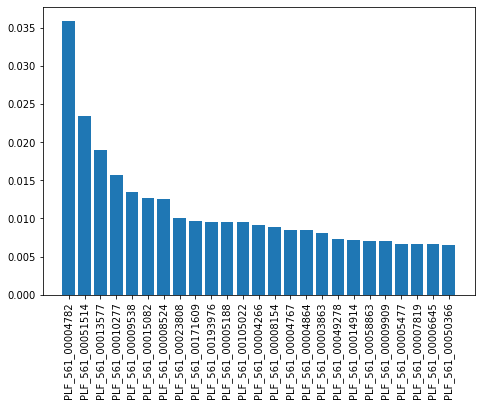

In [140]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation='vertical')
ax.bar(indexlistN[:25],vallistN[:25])
plt.show()

In [141]:
indexlistN[:25]

['PLF_561_00004782',
 'PLF_561_00051514',
 'PLF_561_00013577',
 'PLF_561_00010277',
 'PLF_561_00009538',
 'PLF_561_00015082',
 'PLF_561_00008524',
 'PLF_561_00023808',
 'PLF_561_00171609',
 'PLF_561_00193976',
 'PLF_561_00005188',
 'PLF_561_00105022',
 'PLF_561_00004266',
 'PLF_561_00008154',
 'PLF_561_00004767',
 'PLF_561_00004864',
 'PLF_561_00003863',
 'PLF_561_00049278',
 'PLF_561_00014914',
 'PLF_561_00058863',
 'PLF_561_00009909',
 'PLF_561_00005477',
 'PLF_561_00007819',
 'PLF_561_00006645',
 'PLF_561_00050366']

In [168]:
accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
flist=[]
for train_index, test_index in kfold.split(X[indexlistN[:500]], Y):
    # split data into train/test sets
    x_train_tfidf = X[indexlistN[:500]].iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_test_tfidf = X[indexlistN[:500]].iloc[test_index]
    y_test_tfidf = Y.iloc[test_index]
    trainX, validateX, trainyp, validatey = train_test_split(x_train_tfidf, y_train_tfidf, test_size=0.2, random_state=1989)
    trainyp=trainyp.reset_index(drop=True)
    trainX=trainX.reset_index(drop=True)
    validatey=validatey.reset_index(drop=True)
    validateX=validateX.reset_index(drop=True)

    
    trainy=trainyp.fillna(-1)
    validatey=validatey.fillna(-1)
    Testy=pd.DataFrame(y_test_tfidf).fillna(-1)

    trainy=trainy.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [-1,-1,-1,-1])
    validatey=validatey.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [-1,-1,-1,-1])
    Testy=Testy.replace(['Not defined','Susceptible-dose dependent',0.5,'0.5'], [-1,-1,-1,-1])
    #print(trainy)
    train_labels = np.array(trainy).astype(np.float32)
    val_labels = np.array(validatey).astype(np.float32)
    test_labels = np.array(Testy).astype(np.float32)
    train_features = np.array(trainX).astype(np.float32)
    val_features = np.array(validateX).astype(np.float32)
    test_features = np.array(x_test_tfidf).astype(np.float32)
    
    input_dimension = 1 
    train_sample_size = trainX.shape[0] # number of samples in train set
    test_sample_size = x_test_tfidf.shape[0] # number of samples in train set
    valid_sample_size = validateX.shape[0] # number of samples in train set
    time_steps  = x_test_tfidf.shape[1] # number of features in train set

    test_data_reshaped = test_features.reshape(test_sample_size,time_steps,input_dimension)
    train_data_reshaped = train_features.reshape(train_sample_size,time_steps,input_dimension)
    val_data_reshaped = val_features.reshape(valid_sample_size,time_steps,input_dimension)

    #weight2=weight[:,1:3]
    model = build_conv1D_model(train_data_reshaped)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss= masked_loss_function,
      metrics=METRICS)
    #model.summary()
    '''explaincallbacks = [
    GradientsInputsCallback(
        validation_data=(val_data_reshaped, val_labels),
         class_index=0,
        output_dir=output_dir,
    ),
]'''
    baseline_history = model.fit(
        train_data_reshaped,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
        callbacks=[early_stopping],
        validation_data=(val_data_reshaped, val_labels))
    
    # calculating test accuracy
    results = model.evaluate(test_data_reshaped, test_labels, batch_size=BATCH_SIZE, verbose=1)
    #print (results)
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    flist.append(results[4])
    #explainer = shap.DeepExplainer(model,train_data_reshaped)
    #shap_values = explainer.shap_values(test_data_reshaped)
    #print (shap_values)
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(flist), np.std(flist))

Epoch 1/50
56/56 [==============================] - 2s 33ms/step - loss: 0.1656 - masked_accuracy: 0.7182 - masked_precision: 0.5666 - masked_recall: 0.4189 - masked_f1: 0.4753 - val_loss: 0.1556 - val_masked_accuracy: 0.7620 - val_masked_precision: 0.7186 - val_masked_recall: 0.4217 - val_masked_f1: 0.5272
Epoch 2/50
56/56 [==============================] - 2s 29ms/step - loss: 0.1352 - masked_accuracy: 0.7773 - masked_precision: 0.6653 - masked_recall: 0.5518 - masked_f1: 0.5994 - val_loss: 0.1226 - val_masked_accuracy: 0.8223 - val_masked_precision: 0.7500 - val_masked_recall: 0.6527 - val_masked_f1: 0.6962
Epoch 3/50
56/56 [==============================] - 2s 30ms/step - loss: 0.1180 - masked_accuracy: 0.8128 - masked_precision: 0.7116 - masked_recall: 0.6584 - masked_f1: 0.6804 - val_loss: 0.1155 - val_masked_accuracy: 0.8332 - val_masked_precision: 0.7667 - val_masked_recall: 0.6734 - val_masked_f1: 0.7159
Epoch 4/50
56/56 [==============================] - 2s 30ms/step - loss: 

In [170]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(flist), np.std(flist))

0.8838795741399129 0.008224781144809892 0.8264814496040345 0.01998704940258346 0.781817356745402 0.022739598766255944 0.8007492065429688 0.012957770247703095


In [143]:
trainX, testX, trainy, testy = train_test_split(X[indexlistN[:1000]], Y, test_size=0.2, random_state=1989)
train_trainX, train_validateX, train_trainy, train_validatey = train_test_split(trainX, trainy, test_size=0.2, random_state=1989)

trainy=train_trainy.reset_index(drop=True)
trainX=train_trainX.reset_index(drop=True)
validatey=train_validatey.reset_index(drop=True)
validateX=train_validateX.reset_index(drop=True)

    
trainy=trainy.fillna(-1)
validatey=validatey.fillna(-1)
Testy=testy.fillna(-1)

trainy=trainy.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [0,0,-1,-1])
validatey=validatey.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [0,0,-1,-1])
Testy=Testy.replace(['Not defined','Susceptible-dose dependent',0.5,'0.5'], [-1,-1,-1,-1])
    #print(trainy)
train_labels = np.array(trainy).astype(np.float32)
val_labels = np.array(validatey).astype(np.float32)
test_labels = np.array(Testy).astype(np.float32)
train_features = np.array(trainX).astype(np.float32)
val_features = np.array(validateX).astype(np.float32)
test_features = np.array(testX).astype(np.float32)
    
input_dimension = 1 
train_sample_size = trainX.shape[0] # number of samples in train set
test_sample_size = testX.shape[0] # number of samples in train set
valid_sample_size = validateX.shape[0] # number of samples in train set
time_steps  = testX.shape[1] # number of features in train set

test_data_reshaped = testX.values.reshape(test_sample_size,time_steps,input_dimension)
train_data_reshaped = trainX.values.reshape(train_sample_size,time_steps,input_dimension)
val_data_reshaped = validateX.values.reshape(valid_sample_size,time_steps,input_dimension)

model_G = build_conv1D_model(train_data_reshaped)
#model = tf.keras.models.load_model("../output/maskmodel.h5", custom_objects={'masked_loss_function':                   
#masked_loss_function,'masked_accuracy': masked_accuracy, 'masked_precision': masked_precision,
#'masked_recall': masked_recall, 'masked_f1': masked_f1})
model_G.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss= masked_loss_function,
      metrics=METRICS)

baseline_history = model_G.fit(
        train_data_reshaped,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
        callbacks=[early_stopping],
        validation_data=(val_data_reshaped, val_labels))

    # calculating test accuracy
results = model_G.evaluate(test_data_reshaped, test_labels, batch_size=BATCH_SIZE, verbose=1)
print (results)
print(results[1],results[2],results[3],results[4])

Epoch 1/50
56/56 [==============================] - 4s 57ms/step - loss: 0.1563 - masked_accuracy: 0.7374 - masked_precision: 0.5767 - masked_recall: 0.4749 - masked_f1: 0.5170 - val_loss: 0.1414 - val_masked_accuracy: 0.7838 - val_masked_precision: 0.7535 - val_masked_recall: 0.5635 - val_masked_f1: 0.6437
Epoch 2/50
56/56 [==============================] - 3s 51ms/step - loss: 0.1240 - masked_accuracy: 0.8051 - masked_precision: 0.7001 - masked_recall: 0.6102 - masked_f1: 0.6481 - val_loss: 0.1203 - val_masked_accuracy: 0.8270 - val_masked_precision: 0.7652 - val_masked_recall: 0.7299 - val_masked_f1: 0.7446
Epoch 3/50
56/56 [==============================] - 3s 51ms/step - loss: 0.1140 - masked_accuracy: 0.8264 - masked_precision: 0.7325 - masked_recall: 0.6701 - masked_f1: 0.6933 - val_loss: 0.1107 - val_masked_accuracy: 0.8396 - val_masked_precision: 0.7898 - val_masked_recall: 0.7361 - val_masked_f1: 0.7601
Epoch 4/50
56/56 [==============================] - 3s 51ms/step - loss: 

In [144]:
def get_inputXgradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    #print(img_input.shape)
    images = tf.cast(img_input, tf.float32)
    #print(images.shape)
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        #print (preds)
        top_class = preds[:, top_pred_idx]
        #print (top_class)


    grads = tape.gradient(top_class, images)
    return img_input*grads

In [145]:
trainX, testX, trainy, testy = train_test_split(X, Y, test_size=0.2, random_state=1989)
train_trainX, train_validateX, train_trainy, train_validatey = train_test_split(trainX, trainy, test_size=0.2, random_state=1989)

trainy=train_trainy.reset_index(drop=True)
trainX=train_trainX.reset_index(drop=True)
validatey=train_validatey.reset_index(drop=True)
validateX=train_validateX.reset_index(drop=True)

    
trainy=trainy.fillna(-1)
validatey=validatey.fillna(-1)
Testy=testy.fillna(-1)

trainy=trainy.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [0,0,-1,-1])
validatey=validatey.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [0,0,-1,-1])
Testy=Testy.replace(['Not defined','Susceptible-dose dependent',0.5,'0.5'], [-1,-1,-1,-1])
    #print(trainy)
train_labels = np.array(trainy).astype(np.float32)
val_labels = np.array(validatey).astype(np.float32)
test_labels = np.array(Testy).astype(np.float32)
train_features = np.array(trainX).astype(np.float32)
val_features = np.array(validateX).astype(np.float32)
test_features = np.array(testX).astype(np.float32)
    
input_dimension = 1 
train_sample_size = trainX.shape[0] # number of samples in train set
test_sample_size = testX.shape[0] # number of samples in train set
valid_sample_size = validateX.shape[0] # number of samples in train set
time_steps  = testX.shape[1] # number of features in train set

test_data_reshaped = testX.values.reshape(test_sample_size,time_steps,input_dimension)
train_data_reshaped = trainX.values.reshape(train_sample_size,time_steps,input_dimension)
val_data_reshaped = validateX.values.reshape(valid_sample_size,time_steps,input_dimension)

model = build_conv1D_model(train_data_reshaped)
#model = tf.keras.models.load_model("../output/maskmodel.h5", custom_objects={'masked_loss_function':                   
#masked_loss_function,'masked_accuracy': masked_accuracy, 'masked_precision': masked_precision,
#'masked_recall': masked_recall, 'masked_f1': masked_f1})
model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss= masked_loss_function,
      metrics=METRICS)

baseline_history = model.fit(
        train_data_reshaped,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
        callbacks=[early_stopping],
        validation_data=(val_data_reshaped, val_labels))

    # calculating test accuracy
results = model.evaluate(test_data_reshaped, test_labels, batch_size=BATCH_SIZE, verbose=1)
print (results)
print(results[1],results[2],results[3],results[4])

Epoch 1/50
56/56 [==============================] - 47s 821ms/step - loss: 0.1893 - masked_accuracy: 0.6924 - masked_precision: 0.4947 - masked_recall: 0.4256 - masked_f1: 0.4505 - val_loss: 0.1608 - val_masked_accuracy: 0.7497 - val_masked_precision: 0.7221 - val_masked_recall: 0.4591 - val_masked_f1: 0.5599
Epoch 2/50
56/56 [==============================] - 45s 800ms/step - loss: 0.1387 - masked_accuracy: 0.7812 - masked_precision: 0.6667 - masked_recall: 0.5399 - masked_f1: 0.5915 - val_loss: 0.1293 - val_masked_accuracy: 0.8161 - val_masked_precision: 0.7956 - val_masked_recall: 0.6358 - val_masked_f1: 0.7055
Epoch 3/50
56/56 [==============================] - 44s 788ms/step - loss: 0.1114 - masked_accuracy: 0.8322 - masked_precision: 0.7371 - masked_recall: 0.6756 - masked_f1: 0.7030 - val_loss: 0.1044 - val_masked_accuracy: 0.8520 - val_masked_precision: 0.7921 - val_masked_recall: 0.7800 - val_masked_f1: 0.7843
Epoch 4/50
56/56 [==============================] - 44s 794ms/step 

In [146]:
TotIGShape=[]
for i in range(test_data_reshaped.shape[0]):
    top_pred_idx = tf.argmax(preds[i])
    test_data_reshaped_i=test_data_reshaped[i].reshape(1,test_data_reshaped[i].shape[0],test_data_reshaped[i].shape[1])
    Ngrads = get_inputXgradients(test_data_reshaped_i, top_pred_idx=top_pred_idx)
    avg_NGgrads = tf.reduce_mean(Ngrads, axis=0)
    TotIGShape.append(avg_NGgrads)

In [150]:
TotNGShapedf = pd.DataFrame(columns=trainX.columns.values)
for shp in TotIGShape:
    Valuelist=[]
    with tf.compat.v1.Session() as sess:  
        for value in (shp.numpy()):
            [singleitem] = value
            Valuelist.append(singleitem)
    a_NGseries = pd.Series(Valuelist, index = trainX.columns)
    TotNGShapedf = TotNGShapedf.append(a_NGseries, ignore_index=True)

In [151]:
madNG = TotNGShapedf.mad()
print (madNG)

PLF_561_00000047    0.000001
PLF_561_00004324    0.000000
PLF_561_00003342    0.000010
PLF_561_00000669    0.000016
PLF_561_00003472    0.000000
                      ...   
PLF_561_00086253    0.000000
PLF_561_00047526    0.000000
PLF_561_00047257    0.000000
PLF_561_00035514    0.000000
PLF_561_00108032    0.000000
Length: 16345, dtype: float32


In [152]:
#avg_grads.shape
listoftupleNG=[(i,e) for i, e in enumerate(madNG) if e != 0]
#value=[e for i, e in enumerate(mad) if e != 0]
#listoftuple
from operator import itemgetter, attrgetter    
listoftupleNG1=sorted(listoftupleNG, key=itemgetter(1),reverse=True)


In [153]:
varNGdf=TotNGShapedf.var()

In [154]:
meanvarNGdf=varNGdf.mean(axis=0)
meanvarNGdf

1.4538350114889909e-06

In [155]:
dfmeanNG=TotNGShapedf.mean(axis=0)

In [156]:
indexlistNG=[]
vallistNG=[]
n=0
for i,val in listoftupleNG1:
    print(X.columns[i])
    indexlistNG.append(X.columns[i])
    vallistNG.append(val)
    print(varNGdf[i])
    print (dfmeanNG[i])
    #print(n)
    #if (n >25):
    #    break
    df2 = pd.DataFrame({"ID":[X.columns[i]],
                    "MAD":[val], 
                    "Var":[varNGdf[i]],
                    "val":[dfmeanNG[i]]})
    if (n==0):
        df4=df2
    else:
        df4=df4.append(df2, ignore_index = True)
    n=n+1
    #print(n)
    #if (n >25):
    #    break
df4.to_csv('../output/GradeintInput_Feature_final.csv')



PLF_561_00004782
0.0034764607
0.024151942
PLF_561_00051514
0.0009944063
-0.010443117
PLF_561_00015082
0.00034531378
0.0060306625
PLF_561_00194287
0.00031404576
-0.0057433946
PLF_561_00029585
0.0002183656
-0.0041739293
PLF_561_00032227
0.00033771008
0.003918031
PLF_561_00004864
0.00010319382
-0.0042576534
PLF_561_00003643
0.000121002755
0.0044649863
PLF_561_00005448
0.00019273431
0.0036895168
PLF_561_00017351
0.00017852888
0.0029994606
PLF_561_00006093
0.00023468936
0.0030672061
PLF_561_00005992
0.00019768732
0.0026242367
PLF_561_00059981
8.119452e-05
0.004098122
PLF_561_00005453
7.706854e-05
-0.003640454
PLF_561_00014914
0.00011371138
-0.0029972978
PLF_561_00004266
9.417238e-05
-0.0028753069
PLF_561_00105022
7.937546e-05
-0.0031166049
PLF_561_00010117
0.00014630608
0.002629928
PLF_561_00007868
0.00018366623
-0.0024351908
PLF_561_00003800
5.6423945e-05
0.0031054807
PLF_561_00004546
8.574515e-05
0.0027418341
PLF_561_00050366
0.00020970555
0.002456735
PLF_561_00004767
5.57399e-05
-0.00292

In [173]:
len(indexlistNG)

11749

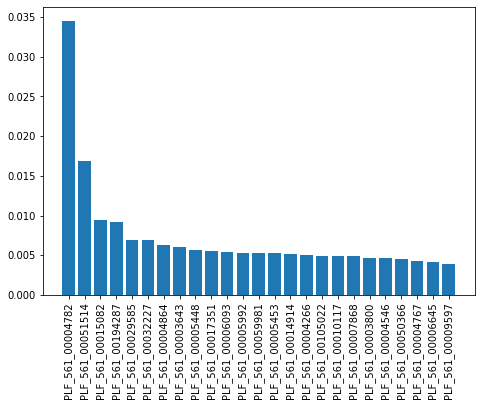

In [158]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation='vertical')
ax.bar(indexlistNG[:25],vallistNG[:25])
plt.show()

In [171]:
accuracyresultlist=[]
precisionresultlist=[]
recallresultlist=[]
flist=[]
for train_index, test_index in kfold.split(X[indexlistNG[:500]], Y):
    # split data into train/test sets
    x_train_tfidf = X[indexlistNG[:500]].iloc[train_index]
    y_train_tfidf = Y.iloc[train_index]
    x_test_tfidf = X[indexlistNG[:500]].iloc[test_index]
    y_test_tfidf = Y.iloc[test_index]
    trainX, validateX, trainyp, validatey = train_test_split(x_train_tfidf, y_train_tfidf, test_size=0.2, random_state=1989)
    trainyp=trainyp.reset_index(drop=True)
    trainX=trainX.reset_index(drop=True)
    validatey=validatey.reset_index(drop=True)
    validateX=validateX.reset_index(drop=True)

    
    trainy=trainyp.fillna(-1)
    validatey=validatey.fillna(-1)
    Testy=pd.DataFrame(y_test_tfidf).fillna(-1)

    trainy=trainy.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [-1,-1,-1,-1])
    validatey=validatey.replace(['Not defined','Susceptible-dose dependent', 0.5,'0.5'], [-1,-1,-1,-1])
    Testy=Testy.replace(['Not defined','Susceptible-dose dependent',0.5,'0.5'], [-1,-1,-1,-1])
    #print(trainy)
    train_labels = np.array(trainy).astype(np.float32)
    val_labels = np.array(validatey).astype(np.float32)
    test_labels = np.array(Testy).astype(np.float32)
    train_features = np.array(trainX).astype(np.float32)
    val_features = np.array(validateX).astype(np.float32)
    test_features = np.array(x_test_tfidf).astype(np.float32)
    
    input_dimension = 1 
    train_sample_size = trainX.shape[0] # number of samples in train set
    test_sample_size = x_test_tfidf.shape[0] # number of samples in train set
    valid_sample_size = validateX.shape[0] # number of samples in train set
    time_steps  = x_test_tfidf.shape[1] # number of features in train set

    test_data_reshaped = test_features.reshape(test_sample_size,time_steps,input_dimension)
    train_data_reshaped = train_features.reshape(train_sample_size,time_steps,input_dimension)
    val_data_reshaped = val_features.reshape(valid_sample_size,time_steps,input_dimension)

    #weight2=weight[:,1:3]
    model = build_conv1D_model(train_data_reshaped)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss= masked_loss_function,
      metrics=METRICS)
    #model.summary()
    '''explaincallbacks = [
    GradientsInputsCallback(
        validation_data=(val_data_reshaped, val_labels),
         class_index=0,
        output_dir=output_dir,
    ),
]'''
    baseline_history = model.fit(
        train_data_reshaped,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        shuffle=True,
        callbacks=[early_stopping],
        validation_data=(val_data_reshaped, val_labels))
    
    # calculating test accuracy
    results = model.evaluate(test_data_reshaped, test_labels, batch_size=BATCH_SIZE, verbose=1)
    #print (results)
    accuracyresultlist.append(results[1])
    precisionresultlist.append(results[2])
    recallresultlist.append(results[3])
    flist.append(results[4])
    #explainer = shap.DeepExplainer(model,train_data_reshaped)
    #shap_values = explainer.shap_values(test_data_reshaped)
    #print (shap_values)
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(flist), np.std(flist))

Epoch 1/50
56/56 [==============================] - 3s 38ms/step - loss: 0.1722 - masked_accuracy: 0.7074 - masked_precision: 0.5338 - masked_recall: 0.4577 - masked_f1: 0.4873 - val_loss: 0.1732 - val_masked_accuracy: 0.7466 - val_masked_precision: 0.6484 - val_masked_recall: 0.4477 - val_masked_f1: 0.5252
Epoch 2/50
56/56 [==============================] - 2s 34ms/step - loss: 0.1439 - masked_accuracy: 0.7593 - masked_precision: 0.6472 - masked_recall: 0.4822 - masked_f1: 0.5476 - val_loss: 0.1343 - val_masked_accuracy: 0.8064 - val_masked_precision: 0.7581 - val_masked_recall: 0.5649 - val_masked_f1: 0.6457
Epoch 3/50
56/56 [==============================] - 2s 33ms/step - loss: 0.1233 - masked_accuracy: 0.8034 - masked_precision: 0.7028 - masked_recall: 0.6282 - masked_f1: 0.6594 - val_loss: 0.1182 - val_masked_accuracy: 0.8240 - val_masked_precision: 0.8155 - val_masked_recall: 0.5650 - val_masked_f1: 0.6645
Epoch 4/50
56/56 [==============================] - 2s 33ms/step - loss: 

In [172]:
print(np.mean(accuracyresultlist),np.std(accuracyresultlist), np.mean(precisionresultlist),np.std(precisionresultlist), np.mean(recallresultlist), np.std(recallresultlist), np.mean(flist), np.std(flist))

0.8856359958648682 0.007196841663482948 0.8360002915064494 0.023313562468951863 0.7753848791122436 0.02273743770382211 0.8017404278119405 0.011158700649173646
